### This notebook contains the following operations
* Load the US Video data with Titles/Tags/Descriptions
* Create iterators for train, validation and test datasets
* Run the analysis with neural network models (including RNN, CNN, and simple Linear NN)
* Run the analysis with Machine Learning Models (logistic regression and random forest) with reduced TFIDF matrix
* Run the analysis with Logistic Regression with Bag of Words of ngrams
* Visualize the comparison of the performances

In [1]:
import data_input as data_in
import nnmodels as nnm
import mlmodels as mlm
import bow_models as bowm
import train_eval
import visualization as vis
from torchtext import data
import torch

### Load Data and Define Train, Valid, and Test Sets for Video Titles/Tags/Descriptions

In [2]:
data_dir = r'D:\Researching Data\Youtube data\USvideos.csv' # should specify the directory for US video data
path = r'D:\Researching Data\Youtube data' # should specify the directory for all video data
MAX_VOCAB_SIZE = 25000
TRAIN_VALID_TEST_R = (0.4, 0.4, 0.2)
BATCH_SIZE = 64

In [3]:
new_TEXT, new_label, new_arr = data_in.load_data(data_dir, 25, "full")
# using title, tags might be problematic for CNN models (the length of sequences)

torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)
train_data, valid_data, test_data = data_in.build_train_test(path, new_arr, TRAIN_VALID_TEST_R, TEXT, LABEL)

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)
device = torch.device('cpu') # switch to local device 
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data_in.build_iterator(BATCH_SIZE, device, train_data, valid_data, test_data)

7.951503700204691  percent of videos are labelled as the selected category
the baseline precision is  7.951503700204691  in this model
The size of train, valid and test data are 2540 2540 1271
Number of training examples: 2539
Number of testing examples: 1270
Number of validation examples:2539


### Run Neural Network Models 

In [4]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_wordem = nnm.WordEmbAvg_2linear(INPUT_DIM, EMBEDDING_DIM, 
                                      HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model_rnn = nnm.SimpleRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, 
                          OUTPUT_DIM, PAD_IDX)
model_BLSTM = nnm.LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                       N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_GRU = nnm.GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                    N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_CNN = nnm.CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, 
                    OUTPUT_DIM, DROPOUT, PAD_IDX)
MODEL_DICT = {"avg_embedding": model_wordem, "SimpleRNN": model_rnn,
              "BLSTM": model_BLSTM, "BGRU": model_GRU, "CNN": model_CNN}

In [5]:
best_models, models_perf = train_eval.compare_models(MODEL_DICT, device, train_iterator, valid_iterator, test_iterator, 5)
train_eval.get_effective_norms(best_models, TEXT)

currently training the model:  avg_embedding
Epoch 0: Dev Accuracy: 0.921875 Dev Loss:0.18504451550543308
Epoch 1: Dev Accuracy: 0.974609375 Dev Loss:0.08347286180360243
Epoch 2: Dev Accuracy: 0.96953125 Dev Loss:0.14287379262459582
Epoch 3: Dev Accuracy: 0.971875 Dev Loss:0.13211882444975345
Epoch 4: Dev Accuracy: 0.971484375 Dev Loss:0.1464085410343614
Test Loss: 0.070 | Test Acc: 97.56%
Test Prec: nan% | Test Rec: 69.611%
currently training the model:  SimpleRNN
Epoch 0: Dev Accuracy: 0.921875 Dev Loss:0.2720166126266122
Epoch 1: Dev Accuracy: 0.919921875 Dev Loss:0.26612907387316226
Epoch 2: Dev Accuracy: 0.91953125 Dev Loss:0.2781876975670457
Epoch 3: Dev Accuracy: 0.9234375 Dev Loss:0.24974535750225185
Epoch 4: Dev Accuracy: 0.9140625 Dev Loss:0.26885282844305036
Test Loss: 0.259 | Test Acc: 92.24%
Test Prec: nan% | Test Rec: 0.000%
currently training the model:  BLSTM
Epoch 0: Dev Accuracy: 0.921875 Dev Loss:0.2836681496351957
Epoch 1: Dev Accuracy: 0.921875 Dev Loss:0.262031521

### Run TFIDF with Machine Learning Models

In [6]:
tfidf_path = r'D:\Researching Data\Youtube data\tfidf' # should specify the directory for video data with TFIDF
TOPK = 5000
K = 500

In [7]:
new_TEXT, new_label, new_arr = data_in.get_tfidf_matrix(data_dir, 25, "full", TOPK)
X_train, y_train, X_valid, y_valid, X_test, y_test =\
data_in.split_reduced_data(tfidf_path, new_TEXT, new_label, 
                           K, TRAIN_VALID_TEST_R)
mlm_perform = mlm.ml_evaluate(mlm.CLFS, mlm.PARAMETER_DICT, X_train, y_train, 
                              X_valid, y_valid, X_test, y_test)

the current shape of the reduced data is  (6351, 5000)
The size of train, valid and test data are 2540 2540 1271
operation of random_forest method begins
the best accuracy for method:  random_forest  is  0.956726986624705
the corresponding precision is :  0.925
the corresponding recall is :  0.4157303370786517
operation of logistics method begins
the best accuracy for method:  logistics  is  0.956726986624705
the corresponding precision is :  0.9722222222222222
the corresponding recall is :  0.39325842696629215


### Run N-Grams and BOW Classifiers

In [8]:
new_TEXT, new_label, new_arr = data_in.load_data(data_dir, 25, "full")
train_indices, valid_indices, test_indices = data_in.split_train_test(new_arr.shape[0], TRAIN_VALID_TEST_R)

X_train_bow = new_TEXT[train_indices]
y_train_bow = new_label[train_indices]
X_valid_bow = new_TEXT[valid_indices]
y_valid_bow = new_label[valid_indices]
X_test_bow = new_TEXT[test_indices]
y_test_bow = new_label[test_indices]

word_to_idx, wtorch = bowm.word_to_index(2, new_TEXT)
dgrams = bowm.word_ngrams(2, X_train_bow)[0]
VOCAB_SIZE = len(word_to_idx)
NUM_LABELS = 2
n = 2

7.951503700204691  percent of videos are labelled as the selected category
the baseline precision is  7.951503700204691  in this model
The size of train, valid and test data are 2540 2540 1271


In [9]:
model = nnm.BoWNN(VOCAB_SIZE, NUM_LABELS)
perf_dict = bowm.run_bow_ngram(model, word_to_idx, wtorch, 
                               X_train_bow, y_train_bow, 
                               X_valid_bow, y_valid_bow, 
                               X_test_bow, y_test_bow, n)

For epoch number  0 , the accuracy for validation set is  0.9716535433070866
For epoch number  1 , the accuracy for validation set is  0.9696850393700788
For epoch number  2 , the accuracy for validation set is  0.9700787401574803
For epoch number  3 , the accuracy for validation set is  0.9700787401574803
For epoch number  4 , the accuracy for validation set is  0.9700787401574803
the accuracy for test set is  0.970102281667978
the presision for test set is  0.8260869565217391
the recall for test set is  0.7755102040816326


### Performance Visualization

In [10]:
vis.alt.renderers.enable("notebook") # specify if you run it with local device
EPOCH = 5

In [11]:
full_perf_df, full_perf_df2, layer_perf_df = vis.process_perf_dict(models_perf, mlm_perform, perf_dict, EPOCH)
plt1 = vis.plot_nn_performance(full_perf_df)
plt2 = vis.plot_best_model(layer_perf_df)

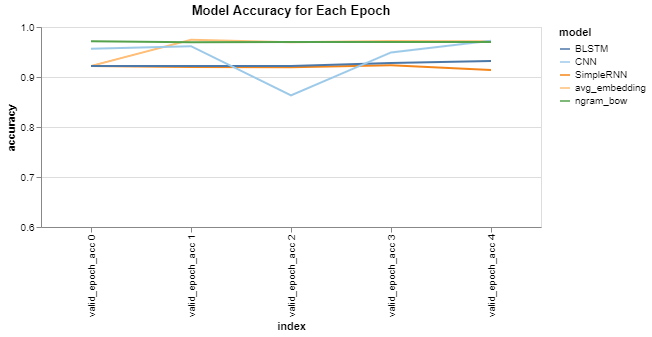

In [12]:
plt1

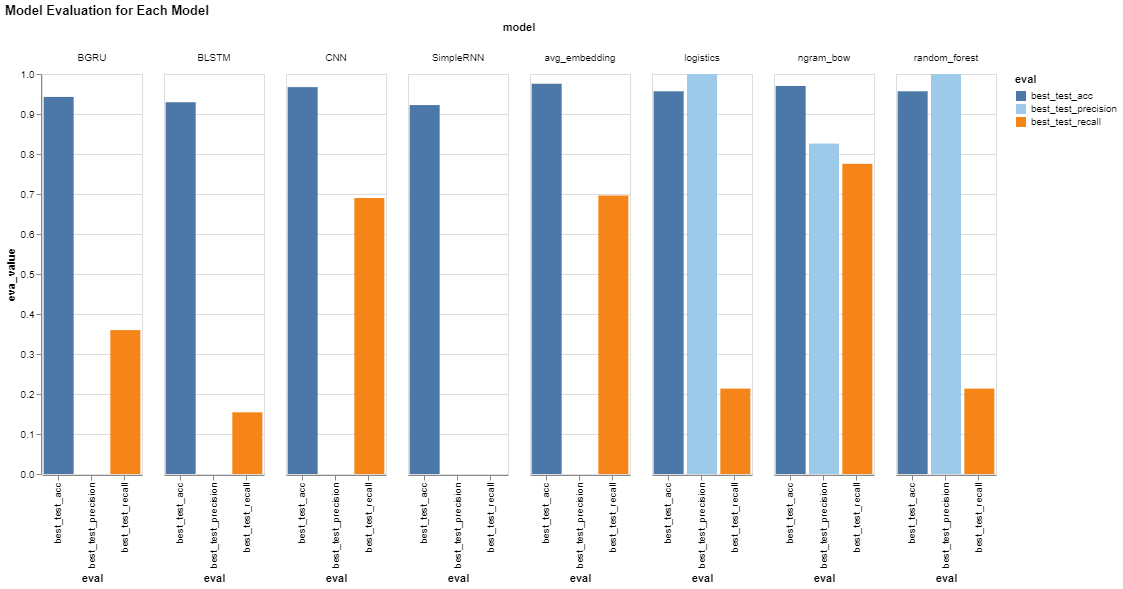

In [13]:
plt2